In [1]:
import numpy as np
from scipy import stats
from numpy import nan
import pandas as pd
import s3fs
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
import statistics
from matplotlib import pyplot as plt
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
import pickle
import shap


In [249]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [4]:
conn = sf_connection()

### Let's read in the features we created

In [5]:
feature_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/score/yes_ecomm.parquet'

In [6]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we read in the label data

In [7]:
label_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv'

In [8]:
label_table = pd.read_csv(label_path, header=0)

In [9]:
label_table.drop(columns={'zero'}, inplace=True)

In [10]:
len(feature_table.drop_duplicates('INDV_ID')), len(label_table.drop_duplicates('INDV_ID'))

(22529095, 22327757)

### Now we inner join on INDV_ID

In [11]:
combined_table = pd.merge(feature_table, label_table, on='INDV_ID', how='inner')

In [12]:
len(combined_table)

22325083

In [13]:
combined_table.drop_duplicates('INDV_ID', inplace=True)

In [14]:
len(combined_table)

22325083

## We now create three more features

In [15]:
combined_table['ecomm_frac'] = combined_table['numEcom']/combined_table['numPurchase']

In [16]:
combined_table['is_sp'] = combined_table['LOYALTY_NUMBER'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
combined_table['is_ecomm'] = combined_table['ecomm_frac'].apply(lambda x: 1 if x > 0.0 else 0)

### Now we join with dim_store to get the market type

In [20]:
store_query = """select STORE_NUMBER, MARKET_CLASS_CODE from PEDW.LOCATION.DIM_STORE_V"""

In [21]:
store_xref = pd.read_sql(store_query, conn)

In [22]:
len(store_xref)

7641

In [23]:
store_xref = store_xref[store_xref.MARKET_CLASS_CODE != 'UNKNOWN'].copy()

In [24]:
len(store_xref)

6021

In [25]:
store_xref['MARKET_CLASS_CODE'] = store_xref['MARKET_CLASS_CODE'].apply(lambda x: int(x))

In [26]:
store_xref.dtypes

STORE_NUMBER         int64
MARKET_CLASS_CODE    int64
dtype: object

In [27]:
store_xref.rename(columns={'STORE_NUMBER': 'FULLFILLMENT_STORE_NUMBER'}, inplace=True)

### Now let's look at distances to AAP and competitor stores

In [28]:
aap_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V 
    where (INDV_ID, STORE_NUMBER, LOAD_TS) in (select INDV_ID, STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V
                                                group by INDV_ID, STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [29]:
aap_dist = pd.read_sql(aap_query, conn)

In [30]:
len(aap_dist)

119871959

In [31]:
comp_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
    where (INDV_ID, CMP_STORE_NUMBER, LOAD_TS) in (select INDV_ID, CMP_STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
                                                group by INDV_ID, CMP_STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [32]:
comp_dist = pd.read_sql(comp_query, conn)

In [33]:
len(comp_dist)

121241967

In [34]:
aap_dist = aap_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'AAP_DIST'})

In [35]:
comp_dist = comp_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'CMP_DIST'})

In [36]:
len(aap_dist), len(aap_dist.drop_duplicates('INDV_ID'))

(119871959, 119871959)

In [37]:
len(comp_dist), len(comp_dist.drop_duplicates('INDV_ID'))

(121241967, 121241967)

### Now let's get the customer lifetime (tenure)

In [38]:
tenure_query = """
    select 
        INDV_ID, 
        datediff(day, INDV_FIRST_TRANSACTION_DATE, '2021-03-01') as TENURE
    from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
    where (INDV_ID,LOAD_TS) in
        (select INDV_ID, max(LOAD_TS) from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
        group by INDV_ID)
        """

In [39]:
tenure = pd.read_sql(tenure_query, conn)

In [40]:
tenure.dtypes

INDV_ID    int64
TENURE     int64
dtype: object

In [41]:
tenure.head()

INDV_ID  TENURE
0  601298104     883
1  572769706    1497
2  299666521    2196
3  136349626    2568
4  233927941    2508

In [104]:
yes_features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'Sends',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [43]:
no_features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [44]:
label = ['3quarter']

In [45]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

### Read the old models

In [46]:
BUCKET = 'aap-aiexpzone-nonpii-mktg-general-results-prod'
ECOMM_KEY = 'DiscountPreference/Models/XGB/xgb.mod'
NO_KEY = 'DiscountPreference/Models/XGB/xgb_no_ecomm.mod'

In [47]:
model_yes = read_pickle_from_s3(BUCKET, ECOMM_KEY)
model_no = read_pickle_from_s3(BUCKET, NO_KEY)

In [48]:
yes_feature_set = set(model_yes.get_booster().feature_names)

In [248]:
len(yes_feature_set)

173

In [103]:
yes_feature_set - set(X_test_yes)

{'Sends', 'TOTAL'}

In [49]:
no_feature_set = set(model_no.get_booster().feature_names)

In [50]:
type(model_yes), type(model_no)

(xgboost.sklearn.XGBClassifier, xgboost.sklearn.XGBClassifier)

In [51]:
len(combined_table)

22325083

### Now we join our new feature dataframes to the table and fill nas

#### First the market code

In [52]:
combined_table = pd.merge(combined_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [53]:
combined_table.isnull().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


#### Fill nulls with 0

In [54]:
combined_table.fillna(0, inplace=True)

#### Now aap store distances

In [55]:
combined_table = pd.merge(combined_table, aap_dist, how='left', on='INDV_ID')

In [56]:
combined_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [57]:
combined_table['AAP_DIST'] = combined_table['AAP_DIST'].fillna(combined_table['AAP_DIST'].mean())

#### Now competitor store distances

In [58]:
combined_table = pd.merge(combined_table, comp_dist, how='left', on='INDV_ID')

In [59]:
combined_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [60]:
combined_table['CMP_DIST'] = combined_table['CMP_DIST'].fillna(combined_table['CMP_DIST'].mean())

In [61]:
combined_table['aap_closer_by'] = combined_table['CMP_DIST'] - combined_table['AAP_DIST']

In [62]:
combined_table['comp_dist_ratio'] = combined_table['CMP_DIST']/combined_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [63]:
combined_table = pd.merge(combined_table, tenure, how='left', on='INDV_ID')

In [64]:
combined_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [65]:
combined_table.loc[(combined_table.TENURE < 1), 'TENURE'] = 1

### We one-hot encode market class

In [66]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [67]:
market_class_feature = onehot_encoder.fit_transform(combined_table[['MARKET_CLASS_CODE']])


In [68]:
market_class_feature.shape

(22325085, 8)

In [69]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [70]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [71]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [72]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [73]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [74]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     0     0    1      0
2     0    0    0      0     0     0    1      0
3     0    0    0      0     0     1    0      0
4     0    0    0      0     0     0    1      0

In [75]:
combined_table.reset_index(drop=True, inplace=True)

In [76]:
len(combined_table), len(market_class_dataframe)

(22325085, 22325085)

In [77]:
combined_table = pd.merge(combined_table, market_class_dataframe, left_index=True, right_index=True)

In [78]:
combined_table.dtypes

INDV_ID                                            object
fyGross                                           float64
2hGross                                           float64
4qGross                                           float64
fyNet                                             float64
2hNet                                             float64
4qNet                                             float64
numEcom                                             int64
numPurchase                                         int64
Recency                                             int32
daysSinceLastPurchase                               int32
isEmployee                                          int32
numReturn                                           int64
numCoupon                                           int64
LOYALTY_NUMBER                                      int64
meanPurchaseTransaction                           float64
FULLFILLMENT_STORE_NUMBER                           int32
pop_est_cy    

In [79]:
combined_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     0     0    1      0                6.000
2      0    0    0      0     0     0    1      0                6.000
3      0    0    0      0     0     1    0      0                5.000
4      0    0    0      0     0     0    1      0                6.000
5      0    0    0      0     0     0    1      0                6.000
6      0    0    0      0     0     0    1      0                6.000
7      0    0    0      0     0     0    1      0                6.000
8      0    0    0      0     0     0    1      0                6.000
9      0    0    0      0     0     0    1      0                6.000
10     0    0    0      0     0     1    0      0                5.000
11     0    0    0      0     1     0    0      0                4.000
12     0    0    0      1     0     0    0      0                3.000
13     0    0    0      0     0     0    1      0                6.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    1      0                6.000
16     0    0    0      0     0     0    1      0                6.000
17     0    0    0      0     0     0    1      0                6.000
18     0    0    0      0     0     0    0      1                7.000
19     0    0    0      0     0     0    1      0                6.000

In [80]:
combined_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [106]:
yes_features = [feature for feature in yes_features if feature != 'MARKET_CLASS_CODE']

In [107]:
no_features = [feature for feature in no_features if feature != 'MARKET_CLASS_CODE']

In [83]:
len(yes_features)

171

In [84]:
len(no_features)

116

In [85]:
yes_table = combined_table[combined_table.is_ecomm==1]

In [431]:
yes_table.mean()

INDV_ID                                             426,957,235.007
fyGross                                                     210.351
2hGross                                                      93.165
4qGross                                                      41.298
fyNet                                                       113.997
2hNet                                                        51.049
4qNet                                                        22.849
numEcom                                                       2.104
numPurchase                                                   3.917
Recency                                                      96.459
daysSinceLastPurchase                                       144.819
isEmployee                                                    0.006
numReturn                                                     0.737
numCoupon                                                     0.880
LOYALTY_NUMBER                            3,534,

In [86]:
no_table = combined_table[combined_table.is_ecomm==0]

In [432]:
no_table.mean()

INDV_ID                                             455,377,588.669
fyGross                                                     131.012
2hGross                                                      62.415
4qGross                                                      29.956
fyNet                                                        79.530
2hNet                                                        38.202
4qNet                                                        18.503
numEcom                                                       0.000
numPurchase                                                   2.625
Recency                                                      71.080
daysSinceLastPurchase                                       149.699
isEmployee                                                    0.007
numReturn                                                     0.478
numCoupon                                                     0.082
LOYALTY_NUMBER                            4,060,

In [88]:
len(yes_table), len(no_table)

(3489566, 18835519)

In [108]:
X_train_yes, X_test_yes, y_train_yes, y_test_yes = train_test_split(yes_table[yes_features], yes_table[label], 
                                                    test_size=0.1, random_state=1, stratify=yes_table[label])

In [109]:
len(X_test_yes)

348957

In [364]:
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(no_table[no_features], no_table[label], 
                                                    test_size=0.1, random_state=1, stratify=no_table[label])

In [365]:
len(X_test_no)

1883552

In [112]:
BUCKET = 'aap-aiexpzone-nonpii-mktg-general-results-prod'
YES_KEY = 'DiscountPreference/Models/XGB/xg_class_yes-5-3.mod'
NO_KEY = 'DiscountPreference/Models/XGB/xg_class_no-5-3.mod'

In [113]:
xg_class_yes = read_pickle_from_s3(BUCKET, ECOMM_KEY)
xg_class_no = read_pickle_from_s3(BUCKET, NO_KEY)

# Now we try SHAP for eCommerce engaged customers

### Beeswarm plot

In [284]:
explainerXGB_yes = shap.TreeExplainer(xg_class_yes)

In [285]:
shap_values = explainerXGB_yes.shap_values(X_test_yes)

In [286]:
shap_obj = explainerXGB_yes(X_test_yes)

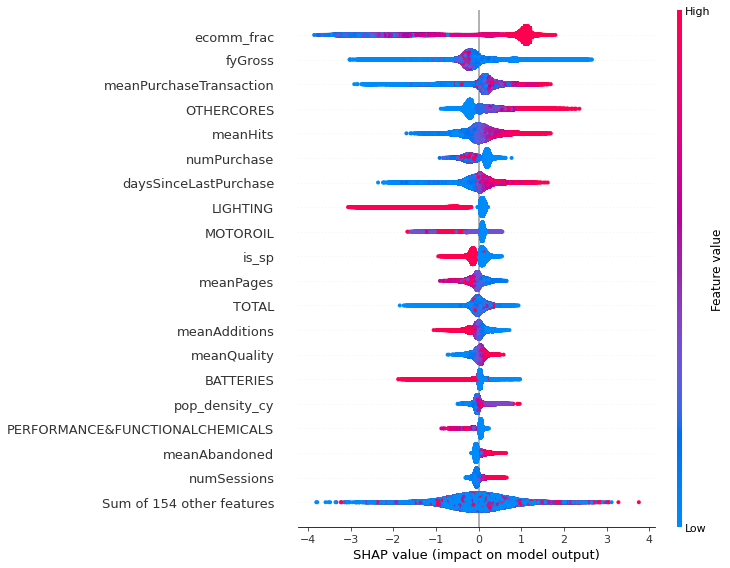

In [287]:
shap.plots.beeswarm(shap_obj, max_display=20)

In [288]:
j=13

In [289]:
shap.initjs()

In [290]:
shap.force_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[j], X_test_yes.iloc[[j]], link='logit')

### We first collect the model predictions and probability scores

In [291]:
test_pred_yes = xg_class_yes.predict(X_test_yes)

In [292]:
test_score_yes = xg_class_yes.predict_proba(X_test_yes)

In [293]:
test_score_unpacked_yes = [score[1] for score in test_score_yes]

### We now collect lists of indexes and statistics for diffeerent catgories

In [294]:
true_positive_indicies = np.where((np.array(y_test_yes).squeeze()==1) & (test_pred_yes==1))

In [295]:
true_negative_indicies = np.where((np.array(y_test_yes).squeeze()==0) & (test_pred_yes==0))

In [296]:
false_positive_indicies = np.where((np.array(y_test_yes).squeeze()==0) & (test_pred_yes==1))

In [297]:
false_negative_indicies = np.where((np.array(y_test_yes).squeeze()==1) & (test_pred_yes==0))

In [298]:
middling_indices = np.where((np.array(test_score_unpacked_yes) < .6) & (np.array(test_score_unpacked_yes) > .4))

In [299]:
high_indices = np.where((np.array(test_score_unpacked_yes) < 1.0) & (np.array(test_score_unpacked_yes) > .9))

In [300]:
low_indices = np.where((np.array(test_score_unpacked_yes) < .4) & (np.array(test_score_unpacked_yes) > 0.0))

In [301]:
true_positive_X_test_yes = X_test_yes.iloc[list(true_positive_indicies[0])]

In [302]:
true_negative_X_test_yes = X_test_yes.iloc[list(true_negative_indicies[0])]

In [303]:
false_positive_X_test_yes = X_test_yes.iloc[list(false_positive_indicies[0])]

In [304]:
false_negative_X_test_yes = X_test_yes.iloc[list(false_negative_indicies[0])]

In [305]:
np.array(test_score_unpacked_yes)[list(true_positive_indicies[0])].mean()

0.88212943

In [306]:
np.array(test_score_unpacked_yes)[list(false_positive_indicies[0])].mean()

0.733784

In [307]:
np.array(test_score_unpacked_yes)[list(true_negative_indicies[0])].mean()

0.07751046

In [308]:
np.array(test_score_unpacked_yes)[list(false_negative_indicies[0])].mean()

0.24284935

In [309]:
np.array(test_score_unpacked_yes)[list(middling_indices[0])].mean()

0.5084415

In [310]:
X_test_yes.mean()

fyGross                                                209.502
numPurchase                                              3.899
Recency                                                 96.322
daysSinceLastPurchase                                  144.633
isEmployee                                               0.006
numReturn                                                0.736
meanPurchaseTransaction                                 64.028
pop_est_cy                                          13,776.623
pop_density_cy                                           0.005
pct_white                                                0.148
age                                                     33.742
pct_college                                              0.135
pct_blue_collar                                          0.178
median_household_income                             54,415.016
establishments                                         445.825
IGNITIONEMISSIONFUELSYSTEMS                            

### Now we look at a couple of true positives

### Strong true postive

In [314]:
set(high_indices[0]).intersection(true_positive_indicies[0])

{0,
 262145,
 262146,
 3,
 262149,
 262150,
 262151,
 262153,
 262159,
 262160,
 262164,
 262168,
 262170,
 30,
 32,
 34,
 35,
 36,
 262183,
 42,
 46,
 262190,
 48,
 262193,
 51,
 54,
 55,
 262199,
 59,
 262204,
 262205,
 64,
 262209,
 66,
 262210,
 262212,
 69,
 262214,
 262215,
 262217,
 75,
 262225,
 82,
 84,
 262228,
 262231,
 88,
 262232,
 90,
 91,
 262237,
 262238,
 262243,
 101,
 262248,
 262249,
 262250,
 262253,
 112,
 116,
 262261,
 262262,
 119,
 121,
 262265,
 123,
 262266,
 262267,
 126,
 127,
 262269,
 131,
 134,
 262280,
 137,
 262283,
 141,
 142,
 143,
 262285,
 262287,
 262290,
 262293,
 150,
 151,
 262298,
 158,
 159,
 262302,
 262305,
 262307,
 262309,
 166,
 262310,
 168,
 262314,
 174,
 176,
 177,
 262320,
 183,
 184,
 262328,
 186,
 187,
 188,
 189,
 190,
 194,
 262339,
 262341,
 262344,
 203,
 262348,
 205,
 262349,
 262353,
 210,
 262360,
 217,
 262362,
 262365,
 223,
 227,
 262374,
 236,
 237,
 262382,
 239,
 242,
 243,
 262386,
 246,
 262390,
 248,
 250,
 2623

In [315]:
np.isin(true_positive_indicies[0], 98971).sum()

1

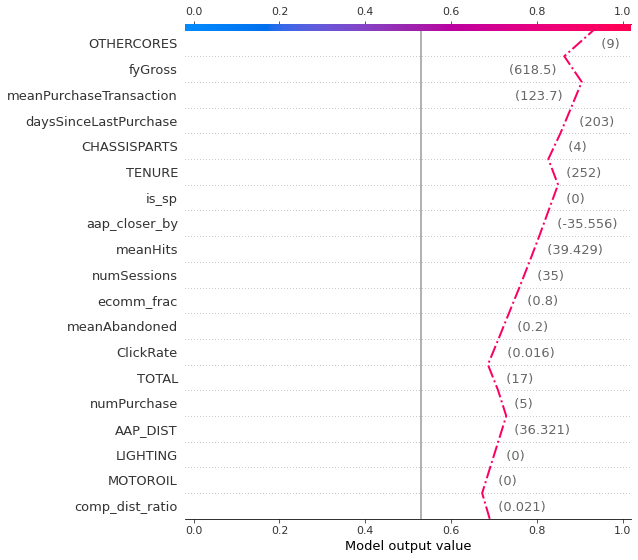

In [317]:
shap.decision_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[[[
       98971]]], feature_names=yes_features, features=X_test_yes.iloc[[
       98971]], feature_display_range=slice(-1, -20, -1),
                   link='logit', highlight=0)

In [318]:
X_test_yes.iloc[98971]

fyGross                                                618.500
numPurchase                                              5.000
Recency                                                 48.000
daysSinceLastPurchase                                  203.000
isEmployee                                               0.000
numReturn                                                3.000
meanPurchaseTransaction                                123.700
pop_est_cy                                          13,055.420
pop_density_cy                                           0.005
pct_white                                                0.230
age                                                     31.430
pct_college                                              0.130
pct_blue_collar                                          0.210
median_household_income                             49,234.641
establishments                                         527.590
IGNITIONEMISSIONFUELSYSTEMS                            

### Difficult True Positive

In [319]:
set(middling_indices[0]).intersection(true_positive_indicies[0])

{131077,
 131084,
 28,
 65564,
 196644,
 65575,
 196651,
 327736,
 163912,
 163913,
 76,
 229459,
 65640,
 32888,
 32892,
 163971,
 295046,
 65691,
 32927,
 164001,
 65715,
 185,
 98492,
 295103,
 229584,
 65756,
 131293,
 164083,
 327923,
 295158,
 327930,
 229628,
 327944,
 295177,
 131341,
 164116,
 98587,
 287,
 65836,
 131378,
 131380,
 229686,
 229696,
 98625,
 229712,
 131410,
 164183,
 33113,
 196953,
 196959,
 98659,
 131430,
 262507,
 229748,
 131446,
 65912,
 262535,
 295311,
 328085,
 262554,
 164251,
 295336,
 65971,
 98739,
 65973,
 229814,
 98758,
 164296,
 295372,
 33236,
 131554,
 66020,
 229863,
 164336,
 66053,
 197135,
 328208,
 328222,
 328224,
 66082,
 66089,
 131625,
 262724,
 66119,
 98890,
 328270,
 591,
 66127,
 131667,
 295513,
 328301,
 164474,
 164475,
 295555,
 164484,
 262791,
 652,
 66191,
 66194,
 164504,
 665,
 230041,
 197275,
 33437,
 33440,
 164512,
 230049,
 684,
 164533,
 66235,
 262846,
 230080,
 295618,
 328399,
 164599,
 328446,
 164610,
 66311

In [325]:
np.isin(true_positive_indicies[0], 229459).sum()

1

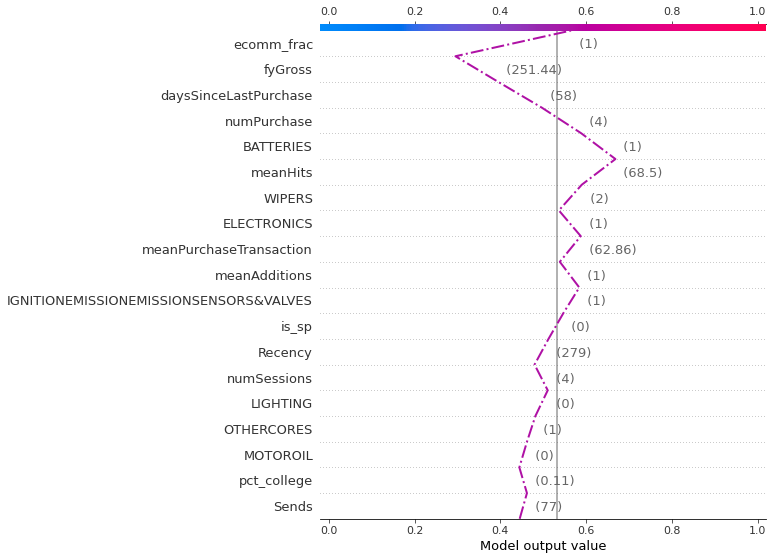

In [324]:
shap.decision_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[[[
       229459]]], feature_names=yes_features, features=X_test_yes.iloc[[
       229459]], feature_display_range=slice(-1, -20, -1),
                   link='logit', highlight=0)

### Firm Negative

In [311]:
set(low_indices[0]).intersection(true_negative_indicies[0])

{262144,
 262147,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 262155,
 15,
 16,
 17,
 18,
 262156,
 262158,
 21,
 262161,
 262163,
 24,
 262166,
 26,
 262172,
 262174,
 31,
 262175,
 262176,
 262177,
 262178,
 262179,
 37,
 262180,
 39,
 262181,
 41,
 262185,
 43,
 262189,
 47,
 262191,
 49,
 262192,
 262194,
 262195,
 53,
 56,
 262200,
 58,
 262201,
 60,
 61,
 262203,
 63,
 262206,
 67,
 68,
 262211,
 70,
 71,
 72,
 73,
 74,
 262218,
 262219,
 77,
 262221,
 262222,
 262223,
 262224,
 262226,
 83,
 262229,
 262230,
 87,
 89,
 262234,
 262235,
 92,
 93,
 262236,
 95,
 262239,
 98,
 262242,
 100,
 262244,
 102,
 103,
 104,
 262247,
 106,
 107,
 110,
 262254,
 262256,
 262258,
 117,
 118,
 262268,
 262270,
 262272,
 129,
 130,
 262274,
 262275,
 262276,
 262277,
 135,
 136,
 262279,
 138,
 139,
 262281,
 262282,
 262284,
 144,
 262288,
 146,
 147,
 262291,
 149,
 262292,
 262295,
 262296,
 153,
 262297,
 155,
 156,
 157,
 262299,
 262300,
 160,
 161,
 162,
 262301,
 164,
 165,
 262306,
 262308,
 262

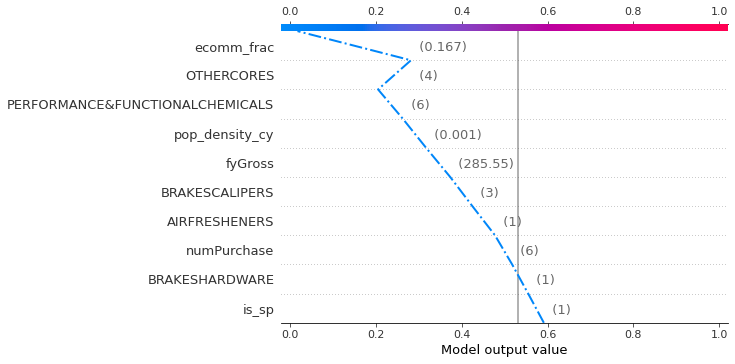

In [312]:
shap.decision_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[13], feature_names=yes_features, features=X_test_yes.iloc[13], feature_display_range=slice(-1, -11, -1),
                   link='logit', highlight=0)

In [313]:
X_test_yes.iloc[13]

fyGross                                                285.550
numPurchase                                              6.000
Recency                                                 49.000
daysSinceLastPurchase                                  265.000
isEmployee                                               0.000
numReturn                                                5.000
meanPurchaseTransaction                                 47.592
pop_est_cy                                          21,380.260
pop_density_cy                                           0.001
pct_white                                                0.740
age                                                     32.400
pct_college                                              0.150
pct_blue_collar                                          0.150
median_household_income                             40,336.590
establishments                                         345.400
IGNITIONEMISSIONFUELSYSTEMS                            

### Weak True Negatives

In [327]:
set(middling_indices[0]).intersection(true_negative_indicies[0])

{32768,
 335873,
 245762,
 163847,
 213000,
 294927,
 73746,
 253972,
 57368,
 213018,
 262171,
 188444,
 65565,
 270363,
 65567,
 344092,
 33,
 24609,
 196641,
 319522,
 81957,
 262188,
 8237,
 163888,
 294961,
 303153,
 344112,
 196665,
 24634,
 81979,
 278586,
 180286,
 237630,
 16448,
 319553,
 188482,
 303170,
 335938,
 98373,
 188485,
 155722,
 24651,
 245835,
 188496,
 81,
 90196,
 270421,
 286806,
 90199,
 57434,
 32864,
 213089,
 213095,
 295015,
 327784,
 65643,
 245867,
 131182,
 49265,
 237682,
 115,
 245874,
 8309,
 254066,
 319603,
 131192,
 147576,
 180344,
 237690,
 295037,
 335997,
 106627,
 229509,
 32904,
 32905,
 139402,
 8334,
 41103,
 73872,
 123024,
 204946,
 278674,
 237717,
 286869,
 213145,
 172186,
 147611,
 172189,
 106654,
 180381,
 229536,
 336031,
 114852,
 147620,
 336037,
 229545,
 16554,
 114858,
 155828,
 336053,
 180410,
 319679,
 344255,
 24770,
 123074,
 344259,
 319686,
 213192,
 164041,
 254156,
 213197,
 8399,
 41170,
 65746,
 237781,
 98520,
 7

In [330]:
np.isin(true_negative_indicies[0], 32768).sum()

1

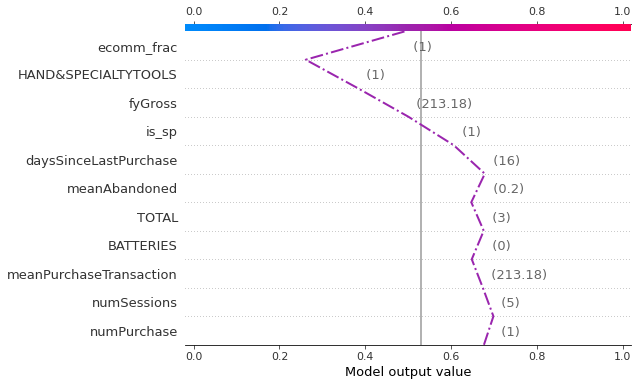

In [430]:
shap.decision_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[[[
       32768]]], feature_names=yes_features, features=X_test_yes.iloc[[
       32768]], feature_display_range=slice(-1, -12, -1),
                   link='logit', highlight=0)

### False Positive

In [333]:
X_test_yes.reset_index(inplace=True, drop=True)

In [336]:
indexes = X_test_yes.index[(X_test_yes.isEmployee == 0)  & (X_test_yes.numPurchase == 4)].tolist()

In [337]:
len(indexes)

21494

In [338]:
set(middling_indices[0]).intersection(set(false_positive_indicies[0]).intersection(set(indexes)))

{657,
 1492,
 1522,
 3704,
 3939,
 5260,
 9286,
 13850,
 13951,
 14693,
 15072,
 20357,
 22817,
 24465,
 25254,
 26896,
 28868,
 29133,
 33939,
 39007,
 39866,
 45073,
 47754,
 48773,
 50900,
 55168,
 58401,
 59509,
 60798,
 63717,
 64084,
 68151,
 69870,
 69872,
 72973,
 76117,
 76383,
 79218,
 83337,
 85089,
 85440,
 88204,
 90638,
 93610,
 94827,
 95070,
 95113,
 100225,
 101275,
 101934,
 104316,
 105565,
 106097,
 107052,
 107553,
 108551,
 110191,
 112373,
 112377,
 112667,
 114700,
 115489,
 115513,
 116305,
 119749,
 122587,
 122632,
 123719,
 127386,
 130158,
 131044,
 132872,
 138202,
 144448,
 146144,
 147077,
 148326,
 150091,
 151519,
 152846,
 153313,
 153385,
 154099,
 154357,
 155027,
 156351,
 157140,
 157148,
 162048,
 163514,
 169592,
 173089,
 178651,
 179155,
 180324,
 180895,
 181160,
 181364,
 190017,
 192103,
 198649,
 198651,
 199688,
 200733,
 202196,
 202678,
 205425,
 206137,
 208044,
 208640,
 208879,
 209490,
 210587,
 212870,
 212964,
 214171,
 214426,
 2

In [339]:
X_test_yes.iloc[657]

fyGross                                                117.320
numPurchase                                              4.000
Recency                                                314.000
daysSinceLastPurchase                                   46.000
isEmployee                                               0.000
numReturn                                                0.000
meanPurchaseTransaction                                 29.330
pop_est_cy                                           6,862.130
pop_density_cy                                           0.007
pct_white                                                0.090
age                                                     36.530
pct_college                                              0.120
pct_blue_collar                                          0.170
median_household_income                             43,499.539
establishments                                         209.900
IGNITIONEMISSIONFUELSYSTEMS                            

In [340]:
y_test_yes.iloc[657]

3quarter    0
Name: 3699606, dtype: int64

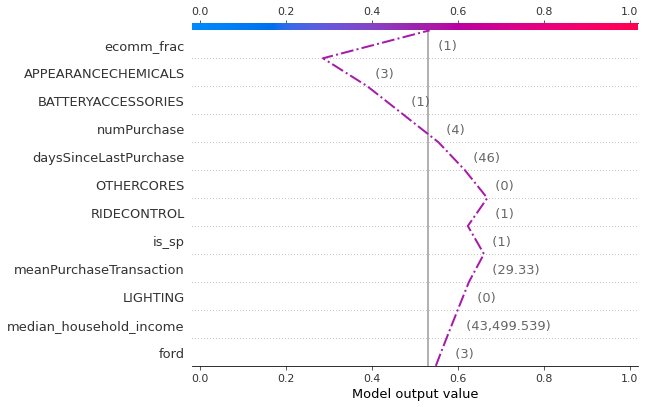

In [341]:
shap.decision_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[[[
       657]]], feature_names=yes_features, features=X_test_yes.iloc[[
       657]], feature_display_range=slice(-1, -13, -1),
                   link='logit', highlight=0)

### False Negative

In [351]:
indexes = X_test_yes.index[(X_test_yes.isEmployee == 0)  & (
    X_test_yes.numPurchase == 4) & (X_test_yes.ecomm_frac == 0.5)].tolist()

In [352]:
len(indexes)

4578

In [353]:
set(middling_indices[0]).intersection(set(false_negative_indicies[0]).intersection(set(indexes)))

{198509}

In [354]:
X_test_yes.iloc[198509]

fyGross                                                169.430
numPurchase                                              4.000
Recency                                                159.000
daysSinceLastPurchase                                  130.000
isEmployee                                               0.000
numReturn                                                3.000
meanPurchaseTransaction                                 42.358
pop_est_cy                                          16,467.330
pop_density_cy                                           0.003
pct_white                                                0.200
age                                                     33.960
pct_college                                              0.160
pct_blue_collar                                          0.200
median_household_income                             61,899.750
establishments                                         453.060
IGNITIONEMISSIONFUELSYSTEMS                            

In [355]:
y_test_yes.iloc[198509]

3quarter    1
Name: 1130329, dtype: int64

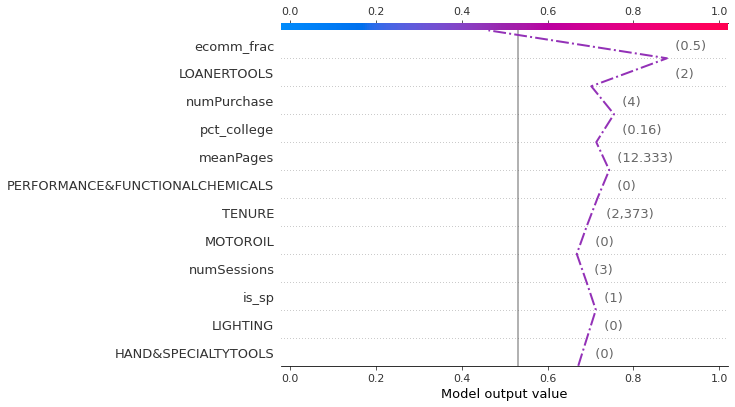

In [356]:
shap.decision_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[[[
       198509]]], feature_names=yes_features, features=X_test_yes.iloc[[
       198509]], feature_display_range=slice(-1, -13, -1),
                   link='logit', highlight=0)

# Now we try SHAP for non-eCommerce engaged customers
### Due to the large size of the data, we only use a subset of the test data

In [366]:
_, X_test_no, _, y_test_no = train_test_split(X_test_no, y_test_no, 
                                                    test_size=0.2, random_state=1, stratify=y_test_no)

In [367]:
test_pred_no = xg_class_no.predict(X_test_no)

In [368]:
test_score_no = xg_class_no.predict_proba(X_test_no)

In [369]:
test_score_unpacked_no = [score[1] for score in test_score_no]

In [370]:
explainerXGB_no = shap.TreeExplainer(xg_class_no)

In [371]:
expected_value = explainerXGB_no.expected_value

In [372]:
shap_obj_no = explainerXGB_no(X_test_no)

In [373]:
len(X_test_no)

376711

In [374]:
shap_values_XGB_test_no = explainerXGB_no.shap_values(X_test_no)

In [375]:
np.array(y_test_no).squeeze().shape

(376711,)

In [376]:
test_pred_no.shape

(376711,)

In [377]:
len(test_score_unpacked_no)

376711

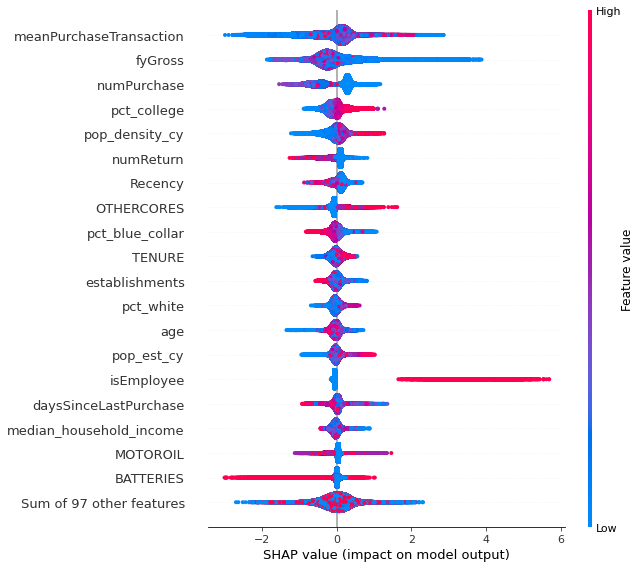

In [378]:
shap.plots.beeswarm(shap_obj_no, max_display=20)

### We now collect lists of indexes for diffeerent catgories

In [379]:
true_positive_indicies = np.where((np.array(y_test_no).squeeze()==1) & (test_pred_no==1))

In [380]:
true_negative_indicies = np.where((np.array(y_test_no).squeeze()==0) & (test_pred_no==0))

In [381]:
false_positive_indicies = np.where((np.array(y_test_no).squeeze()==0) & (test_pred_no==1))

In [382]:
false_negative_indicies = np.where((np.array(y_test_no).squeeze()==1) & (test_pred_no==0))

In [383]:
len(true_positive_indicies[0]), len(true_negative_indicies[0]), len(false_positive_indicies[0]), len(false_negative_indicies[0])

(6790, 352928, 1492, 15501)

In [384]:
middling_indices = np.where((np.array(test_score_unpacked_no) < .6) & (np.array(test_score_unpacked_no) > .4))

In [385]:
high_indices = np.where((np.array(test_score_unpacked_no) < 1.0) & (np.array(test_score_unpacked_no) > .9))

In [386]:
low_indices = np.where((np.array(test_score_unpacked_no) < .4) & (np.array(test_score_unpacked_no) > 0.0))

In [387]:
true_positive_X_test_no = X_test_no.iloc[list(true_positive_indicies[0])]

In [388]:
len(true_positive_X_test_no)

6790

In [389]:
true_negative_X_test_no = X_test_no.iloc[list(true_negative_indicies[0])]

In [390]:
len(true_negative_X_test_no)

352928

In [391]:
false_positive_X_test_no = X_test_no.iloc[list(false_positive_indicies[0])]

In [392]:
len(false_positive_X_test_no)

1492

In [393]:
false_negative_X_test_no = X_test_no.iloc[list(false_negative_indicies[0])]

In [394]:
len(false_negative_X_test_no)

15501

In [395]:
np.array(test_score_unpacked_no)[list(true_positive_indicies[0])].mean()

0.79431784

In [396]:
np.array(test_score_unpacked_no)[list(false_positive_indicies[0])].mean()

0.63935786

In [397]:
np.array(test_score_unpacked_no)[list(true_negative_indicies[0])].mean()

0.040869627

In [398]:
np.array(test_score_unpacked_no)[list(false_negative_indicies[0])].mean()

0.15367414

In [399]:
np.array(test_score_unpacked_no)[list(middling_indices[0])].mean()

0.4899894

### Firm Positive

In [400]:
np.isin(true_positive_indicies[0], 131083).sum()

1

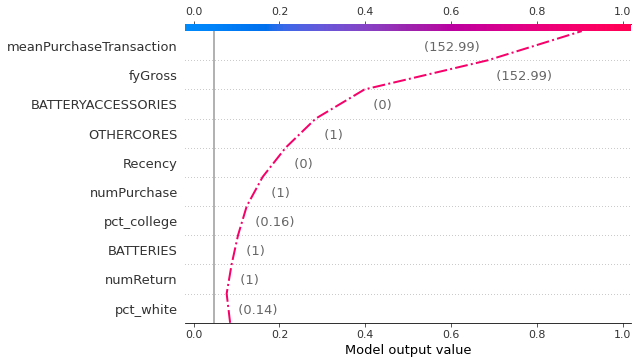

In [401]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[131083], feature_names=no_features, features=X_test_no.iloc[131083], feature_display_range=slice(-1, -11, -1),
                   link='logit', highlight=0)

In [402]:
X_test_no.iloc[131083]

fyGross                                                152.990
numPurchase                                              1.000
Recency                                                  0.000
daysSinceLastPurchase                                   26.000
isEmployee                                               0.000
numReturn                                                1.000
meanPurchaseTransaction                                152.990
pop_est_cy                                           9,787.460
pop_density_cy                                           0.004
pct_white                                                0.140
age                                                     33.070
pct_college                                              0.160
pct_blue_collar                                          0.180
median_household_income                             49,007.109
establishments                                         255.990
IGNITIONEMISSIONFUELSYSTEMS                            

In [403]:
np.isin(true_positive_indicies[0], 223).sum()

1

### Weak Positive

In [404]:
np.isin(true_positive_indicies[0], 223).sum()

1

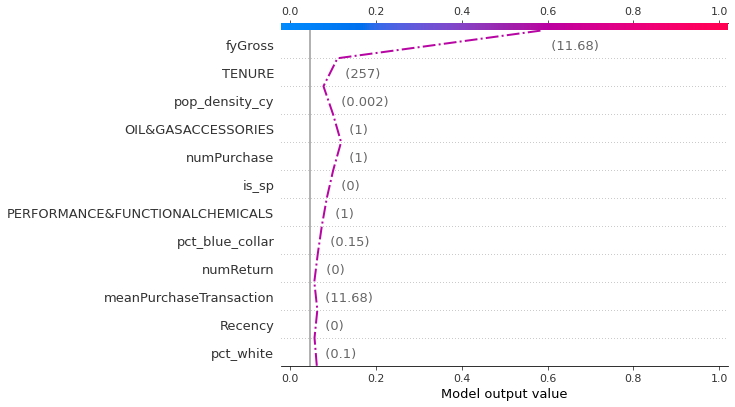

In [405]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       223]]], feature_names=no_features, features=X_test_no.iloc[[
       223]], feature_display_range=slice(-1, -13, -1),
                   link='logit', highlight=0)

In [406]:
X_test_no.iloc[223]

fyGross                                                 11.680
numPurchase                                              1.000
Recency                                                  0.000
daysSinceLastPurchase                                  256.000
isEmployee                                               0.000
numReturn                                                0.000
meanPurchaseTransaction                                 11.680
pop_est_cy                                          12,711.100
pop_density_cy                                           0.002
pct_white                                                0.100
age                                                     31.840
pct_college                                              0.150
pct_blue_collar                                          0.150
median_household_income                             61,497.449
establishments                                         615.520
IGNITIONEMISSIONFUELSYSTEMS                            

### Firm Negative

In [407]:
X_test_no.reset_index(inplace=True, drop=True)

In [408]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 20)].tolist()

In [409]:
len(indexes)

1825

In [410]:
set(low_indices[0]).intersection(set(true_negative_indicies[0]).intersection(set(indexes)))

{253958,
 286726,
 16395,
 270347,
 368676,
 40998,
 245808,
 73781,
 278583,
 81976,
 139326,
 245840,
 8291,
 16492,
 229484,
 139376,
 147576,
 295032,
 147582,
 90242,
 295048,
 139403,
 155795,
 196755,
 311445,
 123032,
 172184,
 254111,
 73894,
 237735,
 270504,
 311463,
 221356,
 254128,
 73907,
 114879,
 237761,
 368839,
 188616,
 8393,
 327885,
 106703,
 32979,
 98515,
 311508,
 352473,
 286942,
 123115,
 16632,
 131326,
 24834,
 82179,
 254222,
 24847,
 205077,
 344352,
 319778,
 237880,
 147772,
 131389,
 115014,
 246093,
 155989,
 82264,
 24921,
 262489,
 287070,
 24927,
 213345,
 74086,
 213353,
 115068,
 205194,
 8591,
 262545,
 336273,
 319893,
 270743,
 295324,
 205219,
 237992,
 33195,
 246195,
 246206,
 205253,
 229830,
 147918,
 352726,
 254431,
 90593,
 16866,
 238051,
 246241,
 270820,
 279017,
 205303,
 172547,
 311811,
 369159,
 90632,
 246283,
 262668,
 16911,
 147988,
 311832,
 188968,
 180777,
 344620,
 98864,
 568,
 180793,
 16952,
 148025,
 25150,
 139838,


In [411]:
X_test_no.iloc[253958]

fyGross                                              1,420.100
numPurchase                                             30.000
Recency                                                298.000
daysSinceLastPurchase                                   40.000
isEmployee                                               0.000
numReturn                                                4.000
meanPurchaseTransaction                                 47.337
pop_est_cy                                          16,554.961
pop_density_cy                                           0.005
pct_white                                                0.080
age                                                     36.400
pct_college                                              0.160
pct_blue_collar                                          0.170
median_household_income                             47,522.379
establishments                                         640.880
IGNITIONEMISSIONFUELSYSTEMS                            

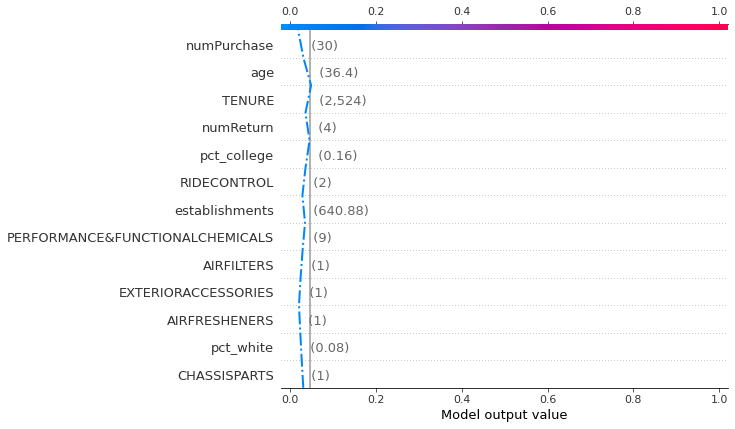

In [412]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       253958]]], feature_names=no_features, features=X_test_no.iloc[[
       253958]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

### Weak Negative

In [413]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 5)].tolist()

In [414]:
len(indexes)

32958

In [415]:
set(middling_indices[0]).intersection(set(true_negative_indicies[0]).intersection(set(indexes)))

{13020,
 13052,
 26224,
 32876,
 42092,
 56747,
 57100,
 72137,
 88150,
 90911,
 91815,
 92776,
 96446,
 97434,
 104495,
 131045,
 138552,
 155910,
 157394,
 187795,
 211128,
 216010,
 263418,
 270698,
 307248,
 310080,
 326334,
 361234,
 364197}

In [416]:
X_test_no.iloc[13020]

fyGross                                                180.210
numPurchase                                              6.000
Recency                                                335.000
daysSinceLastPurchase                                   18.000
isEmployee                                               0.000
numReturn                                                0.000
meanPurchaseTransaction                                 30.035
pop_est_cy                                          15,670.230
pop_density_cy                                           0.004
pct_white                                                0.230
age                                                     30.020
pct_college                                              0.170
pct_blue_collar                                          0.160
median_household_income                             51,498.250
establishments                                         274.310
IGNITIONEMISSIONFUELSYSTEMS                            

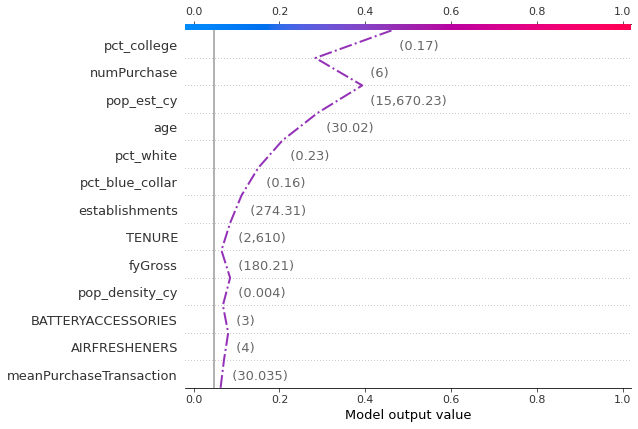

In [417]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       13020]]], feature_names=no_features, features=X_test_no.iloc[[
       13020]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

### False Positive

In [418]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 3)].tolist()

In [419]:
len(indexes)

66457

In [420]:
set(middling_indices[0]).intersection(set(false_positive_indicies[0]).intersection(set(indexes)))

{1149,
 7182,
 11650,
 13883,
 17323,
 18149,
 21331,
 24661,
 27120,
 47737,
 49568,
 63874,
 72451,
 92048,
 94129,
 132560,
 166513,
 169696,
 171466,
 184345,
 184521,
 188847,
 198826,
 209882,
 216761,
 217507,
 218746,
 229466,
 238112,
 250200,
 258235,
 258674,
 260698,
 261373,
 271466,
 272600,
 273025,
 290449,
 293893,
 298051,
 305806,
 312624,
 327139,
 330472,
 338156,
 341355}

In [421]:
X_test_no.iloc[7182]

fyGross                                                 56.530
numPurchase                                              5.000
Recency                                                181.000
daysSinceLastPurchase                                   41.000
isEmployee                                               0.000
numReturn                                                0.000
meanPurchaseTransaction                                 11.306
pop_est_cy                                          14,739.950
pop_density_cy                                           0.005
pct_white                                                0.160
age                                                     32.690
pct_college                                              0.170
pct_blue_collar                                          0.150
median_household_income                             52,418.121
establishments                                         185.970
IGNITIONEMISSIONFUELSYSTEMS                            

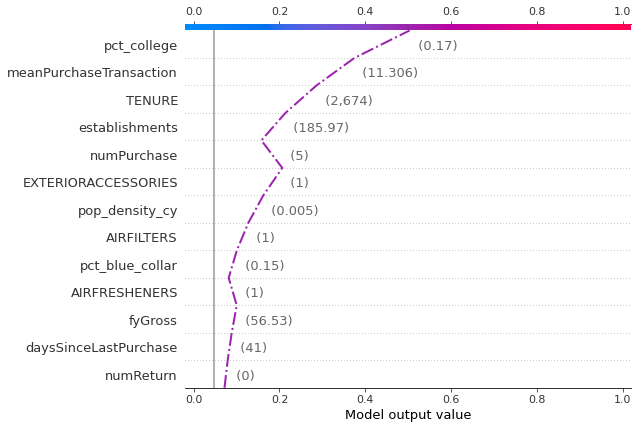

In [422]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       7182]]], feature_names=no_features, features=X_test_no.iloc[[
       7182]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

### False Negative

In [423]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 3)].tolist()

In [424]:
len(indexes)

66457

In [425]:
set(middling_indices[0]).intersection(set(false_negative_indicies[0]).intersection(set(indexes)))

{8531,
 8823,
 19500,
 24723,
 32843,
 49179,
 57253,
 57844,
 58805,
 82082,
 87959,
 113011,
 113530,
 124431,
 129359,
 134259,
 158661,
 159611,
 168671,
 174784,
 175509,
 183581,
 185748,
 212916,
 219503,
 233955,
 237381,
 249040,
 249788,
 256572,
 277211,
 279922,
 280698,
 282198,
 284563,
 311557,
 333937,
 351500,
 357109,
 359559,
 364974,
 375769}

In [426]:
X_test_no.iloc[8531]

fyGross                                              1,281.370
numPurchase                                             25.000
Recency                                                361.000
daysSinceLastPurchase                                    2.000
isEmployee                                               0.000
numReturn                                                4.000
meanPurchaseTransaction                                 51.255
pop_est_cy                                          18,324.350
pop_density_cy                                           0.004
pct_white                                                0.250
age                                                     31.540
pct_college                                              0.160
pct_blue_collar                                          0.170
median_household_income                             46,039.898
establishments                                         261.380
IGNITIONEMISSIONFUELSYSTEMS                            

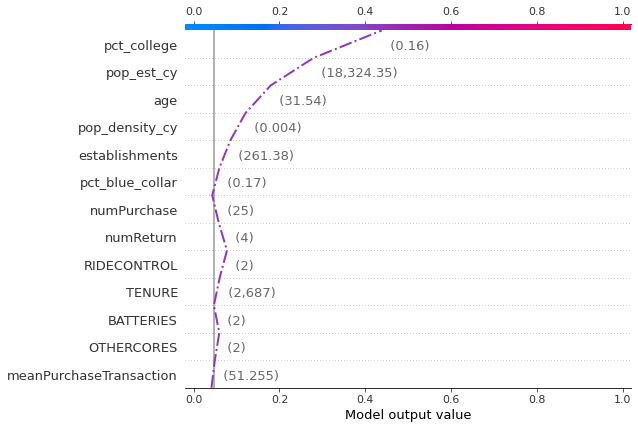

In [427]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       8531]]], feature_names=no_features, features=X_test_no.iloc[[
       8531]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

In [428]:
X_test_no.mean()

fyGross                                                130.859
numPurchase                                              2.627
Recency                                                 71.339
daysSinceLastPurchase                                  149.529
isEmployee                                               0.007
numReturn                                                0.480
meanPurchaseTransaction                                 56.403
pop_est_cy                                          13,593.533
pop_density_cy                                           0.005
pct_white                                                0.174
age                                                     33.699
pct_college                                              0.133
pct_blue_collar                                          0.181
median_household_income                             52,301.070
establishments                                         414.322
IGNITIONEMISSIONFUELSYSTEMS                            